# Exploratory Data Analysis

##### Installations & necessary imports

In [1]:
! pip install plotly
! pip install nltk
! pip install vaderSentiment
! pip install textblob
! pip install scikit-learn
! pip install torch torchvision

In [2]:
## All importations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import os

import re
from textblob import TextBlob
import nltk
from nltk.tokenize import sent_tokenize
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/ines/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

##### Data importation

In [4]:
## Checking if movies in movie.metadata.tsv come from the United states of America

# Importing the data
movies = pd.read_csv('MovieSummaries/movie.metadata.tsv', sep = '\t', header = None)
characters = pd.read_csv('MovieSummaries/character.metadata.tsv', sep = '\t', header = None)

# Importing txt files
name_clusters = pd.read_csv('MovieSummaries/name.clusters.txt', sep = '\t', header = None)
summaries = pd.read_csv('MovieSummaries/plot_summaries.txt', sep = '\t', header = None)
tv_tropes = pd.read_csv('MovieSummaries/tvtropes.clusters.txt', sep = '\t', header = None)

In [5]:
movies.head(2)

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."


In [6]:
name_clusters.head(2)

,0,1
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx


In [7]:
# Renaming columns for each dataframe
movies.columns = ['wikipedia_movie_id', 'freebase_movie_id', 'movie_name', 'movie_release_date', 'movie_box_office_revenue', 'movie_runtime', 'movie_languages', 'movie_countries', 'movie_genres']
#characters.columns = ['wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date', 'character_name', 'actor_DOB', 'actor_gender', 'height', 'ethnicity', 'actor_name', 'actor_age', 'freebase_character_map']
name_clusters.columns = ['name', 'freebase_movie_id']
summaries.columns = ['wikipedia_movie_id', 'plot_summary']
#tv_tropes.columns = ['tropes', 'main_info']

## Visualisation of CMU dataset ++ Cleaning

In [8]:
print((movies.isna().sum() / movies.shape[0]) * 100)

wikipedia_movie_id           0.000000
freebase_movie_id            0.000000
movie_name                   0.000000
movie_release_date           8.443743
movie_box_office_revenue    89.722416
movie_runtime               25.018045
movie_languages              0.000000
movie_countries              0.000000
movie_genres                 0.000000
dtype: float64


In [9]:
def extract_language(language_data):
    language_names = []
    pattern = r'"([^"]+)"\s*:\s*"([^"]+)"'
    matches = re.findall(pattern, language_data)
    for match in matches:
        language_names.append(match[1].split(' ')[0])  # Extract the language name
    return ','.join(language_names)

def extract_countries(country_data):
    country_names = []
    pattern = r'"([^"]+)"\s*:\s*"([^"]+)"'
    matches = re.findall(pattern, country_data)
    for match in matches:
        country_names.append(match[1])  # Extract the country name
    return ','.join(country_names)


def extract_genres(genre_data):
    genre_names = []
    pattern = r'"([^"]+)"\s*:\s*"([^"]+)"'
    matches = re.findall(pattern, genre_data)
    for match in matches:
        genre_names.append(match[1])  # Extract the genre name
    return ','.join(genre_names)


In [10]:
movies["movie_languages"] = movies["movie_languages"].apply(extract_language) # extract languages
movies["movie_countries"] = movies["movie_countries"].apply(extract_countries) # extract country names
movies["movie_genres"] = movies["movie_genres"].apply(extract_genres) # extract genres

movies['movie_genres'] = movies['movie_genres'].apply(lambda x: x.split(','))
movies['movie_countries'] = movies['movie_countries'].apply(lambda x: x.split(','))
movies['movie_languages'] = movies['movie_languages'].apply(lambda x: x.split(','))

movies.head(2)

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"


In [11]:
## Merging movies and summaries
movies_summaries = movies.merge(summaries, how = 'inner', on = 'wikipedia_movie_id')
movies_summaries.head(2)

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,plot_summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...


In [12]:
import plotly.express as px

## Filtering data to keep only movies with non NaN values in box office revenue
movies_summaries = movies_summaries[movies_summaries['movie_box_office_revenue'].notna()]


fig = px.histogram(movies_summaries, x = 'movie_box_office_revenue', nbins = 50)
fig.show()


In [13]:
print(movies_summaries['movie_box_office_revenue'].min())
print(movies_summaries['movie_box_office_revenue'].max())

10200.0
2782275172.0


## Sentiment analysis

In [14]:
## dataframe with only box office revenue, wikipedia movie id and plot summary
df_original = movies_summaries[['movie_box_office_revenue', 'wikipedia_movie_id', 'plot_summary']]
df_original.head(3)

,movie_box_office_revenue,wikipedia_movie_id,plot_summary
0,14010832.0,975900,"Set in the second half of the 22nd century, th..."
5,10161099.0,171005,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
8,102272727.0,77856,The film opens with Mary Poppins perched in a...


In [15]:
## Cleaning text

def clean_text(text):
    # Remove all '{{XX}}' patterns, HTML tags if any & extra white spaces
    text = re.sub(r'\{\{[^}]*\}\}', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove each specific typos
    specific_strings = [r'\{\{Plot\|date', r'\{\{plot\|date', r'\{\{plot\|section\|date', r'\{\{Plot\|section\|date']
    for string in specific_strings:
        text = re.sub(string, '', text)

    return text


In [16]:
df = df_original.copy()
# Apply the cleaning function to the plot summaries to modify directly the plot_summary column
df['cleaned_plot_summary'] = df['plot_summary'].apply(clean_text)
df.drop(columns=['plot_summary'], inplace=True)
df.head(18)

,movie_box_office_revenue,wikipedia_movie_id,cleaned_plot_summary
0,14010832.0,975900,"Set in the second half of the 22nd century, th..."
5,10161099.0,171005,Act 1Act 2Act 3Act 4Act 5 Finally negotiations...
8,102272727.0,77856,The film opens with Mary Poppins perched in a ...
12,29381649.0,156558,A young 20-year-old named Jody lives with his ...
22,34331783.0,261237,The film is a collision of three separate stor...
23,11091868.0,12008535,"In the fictional farming village of Tlachtlán,..."
24,3416846.0,4951456,A Japanese businessman sees a woman being grop...
25,172055.0,5708633,The Great New Wonderful is a series of vignett...
26,3960327.0,12053509,"Randy Bodek is a rebellious college slacker, l..."
37,3600000.0,7028314,"Sir Philip Ashlow , his neglected wife, Lady A..."


In [17]:
## Functions for sentiment analysis

# perform sentiment analysis on the whole summary
def text_sentiment(text):
    blob_text = TextBlob(text)
    # Get the polarity score (-1 to 1)
    polarity = blob_text.sentiment.polarity
    return polarity

# perform sentiment analysis on each sentence
def count_sentences(text):
    sentences = sent_tokenize(text)
    return len(sentences)


def sentences_sentiment(text):
    sentences = sent_tokenize(text)
    if len(sentences) == 0:
        return 0  # Return a neutral score for empty or very short summaries
    sentiment_scores = [TextBlob(sentence).sentiment.polarity for sentence in sentences]
    # average_sentiment = sum(sentiment_scores) / len(sentiment_scores)
    return sentiment_scores


def mean_std(scores):
    if scores:
        return np.mean(scores), np.std(scores)
    return 0, 0  # 0 for empty lists


# Function to classify sentiment into one of five categories
def classify_sentiment(score):
    if score > 0.06:
        return 'positive'
    elif score > 0.02:
        return 'somewhat positive'
    elif score > -0.02:
        return 'neutral'
    elif score > -0.06:
        return 'somewhat negative'
    else:
        return 'negative'

In [18]:
df['sentiment_score'] = df['cleaned_plot_summary'].apply(text_sentiment)
df['sentence_count'] = df['cleaned_plot_summary'].apply(count_sentences)
df['sentences_scores'] = df['cleaned_plot_summary'].apply(sentences_sentiment)
df['mean_sentiment'], df['std_sentiment'] = zip(*df['sentences_scores'].apply(mean_std))


In [19]:
df.head(2)

,movie_box_office_revenue,wikipedia_movie_id,cleaned_plot_summary,sentiment_score,sentence_count,sentences_scores,mean_sentiment,std_sentiment
0,14010832.0,975900,"Set in the second half of the 22nd century, th...",-0.085095,15,"[-0.08333333333333333, 0.35714285714285715, -0...",-0.081468,0.282960
5,10161099.0,171005,Act 1Act 2Act 3Act 4Act 5 Finally negotiations...,-0.006250,3,"[0.0, 0.0, -0.016666666666666666]",-0.005556,0.007857


In [20]:
## distribution of sentence count
fig = px.histogram(df, x = 'sentence_count')
fig.show()

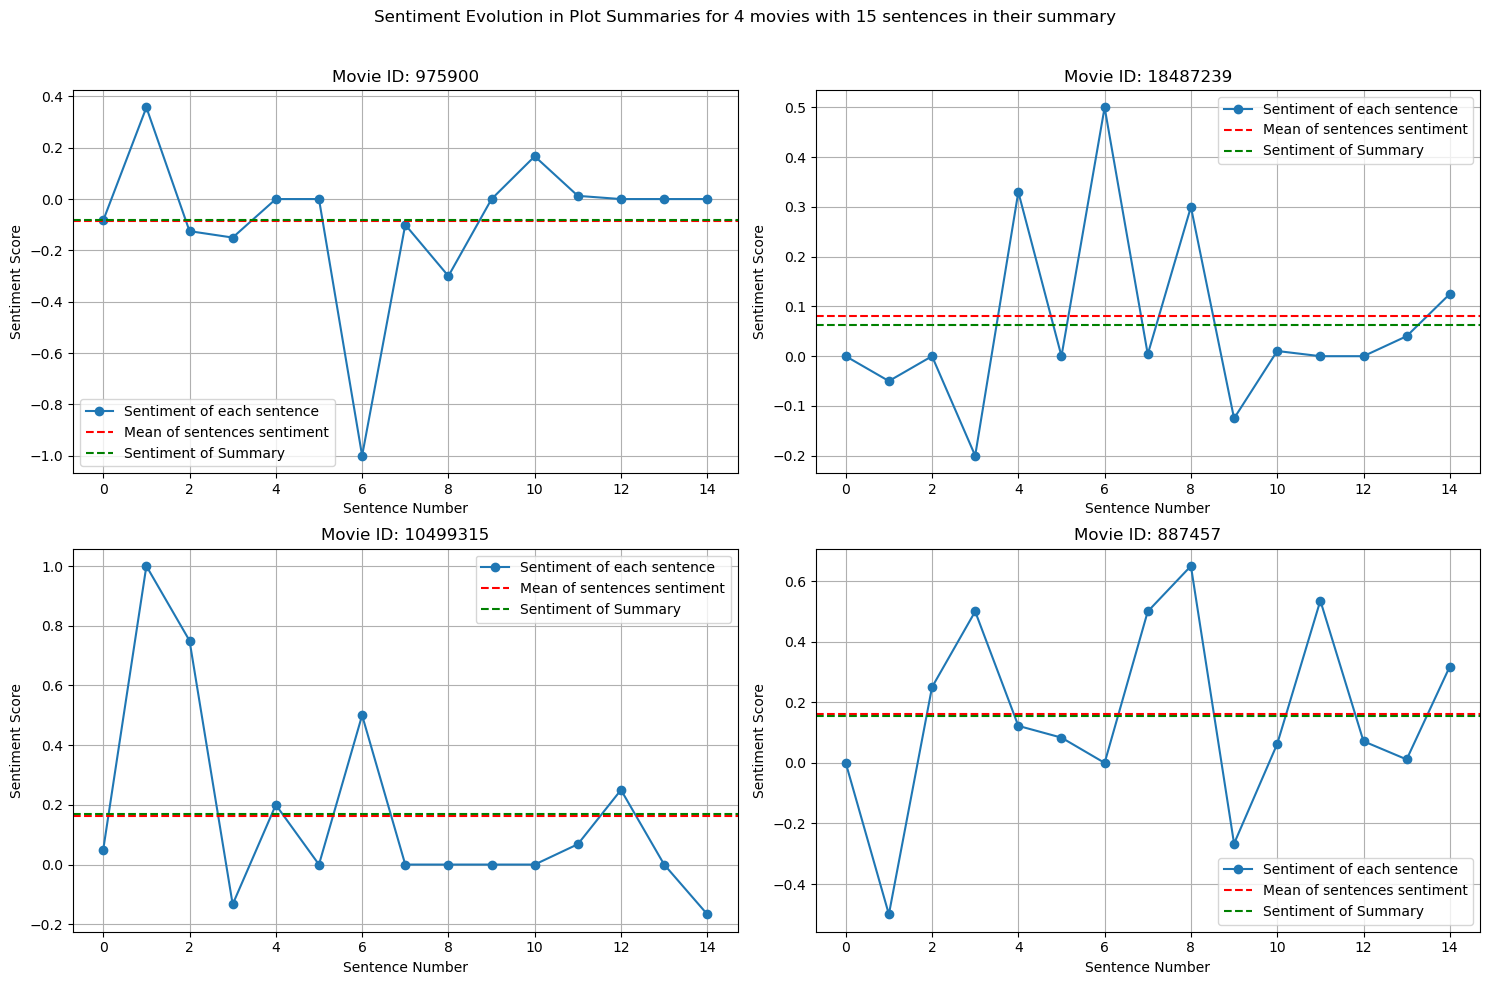

In [21]:
# Filter entries with a sentence count of 20 - for visualisation purposes
subset_df = df[df['sentence_count'] == 15]
sub_entries = subset_df.head(4)

# Plotting the sentiment scores for each summary
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Sentiment Evolution in Plot Summaries for 4 movies with 15 sentences in their summary')
axes = axes.flatten()

for ax, (index, row) in zip(axes, sub_entries.iterrows()):
    sentiment_scores = row['sentences_scores']
    overall_sentiment = row['sentiment_score']  # Overall sentiment score of the summary
    summary_sentiment = row['mean_sentiment']  # Mean sentiment score of the summary
    ax.plot(sentiment_scores, marker='o', label = 'Sentiment of each sentence')
    ax.axhline(y=overall_sentiment, color='r', linestyle='--', label='Mean of sentences sentiment')
    ax.axhline(y=summary_sentiment, color='g', linestyle='--', label='Sentiment of Summary')
    ax.set_title(f"Movie ID: {row['wikipedia_movie_id']}")
    ax.set_xlabel('Sentence Number')
    ax.set_ylabel('Sentiment Score')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.9) 
plt.show()


In [22]:
# Compute error between mean_sentiment and sentiment_score
df['error'] = df['mean_sentiment'] - df['sentiment_score']

# Plotting the error for each summary depending on number of sentences (grouping)
grouped_mean_error = df.groupby('sentence_count')['error'].mean()
print(grouped_mean_error[9:])

sentence_count
10    -0.010229
11    -0.012342
12    -0.018859
13    -0.007203
14    -0.015772
         ...   
145   -0.003026
178   -0.017772
179   -0.000756
202    0.010628
218    0.026723
Name: error, Length: 107, dtype: float64


As we can see, the difference between the mean sentiment score of all sentences and the overall sentiment score of a plot is minimal. Thus for simplicity we can only consider the mean score of all sentiment scores of sentences in a plot summary. To add a layer of complexity, and to show the variation of the sentiment score throughout a summary, we keep the standard deviation of the sentiment score of sentences in a plot summary. We will use these values to try to correlate box office success and sentiment score.

In [23]:
df['label'] = df['sentiment_score'].apply(classify_sentiment)
df.head(2)

## value count for each label
print(df['label'].value_counts())

label
positive             2949
somewhat positive    1502
neutral              1400
somewhat negative     912
negative              824
Name: count, dtype: int64


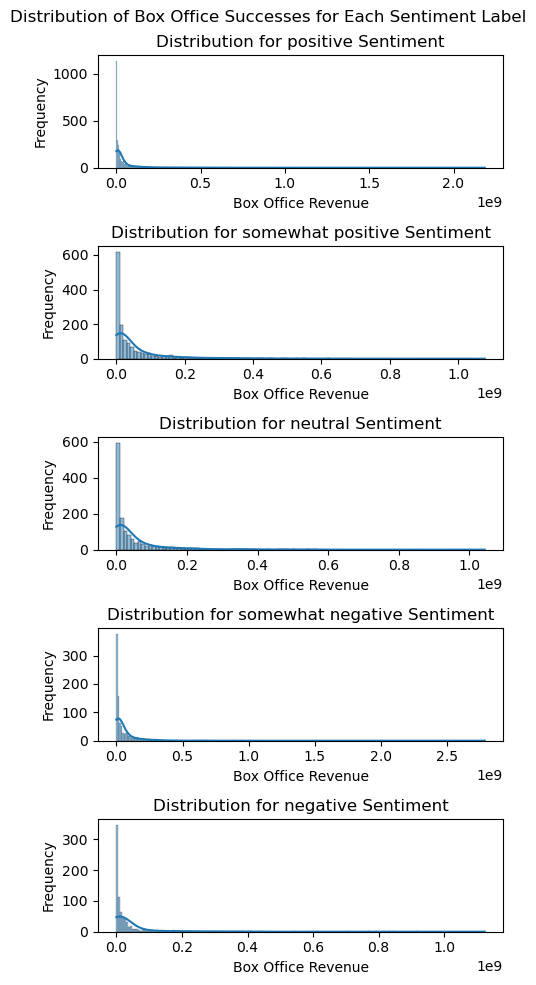

In [24]:
## Plotting the distribution of box office revenues according to the sentiment of the plot summary
labels = ['positive', 'somewhat positive', 'neutral', 'somewhat negative', 'negative']

# Creating subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(5, 10))
fig.suptitle('Distribution of Box Office Successes for Each Sentiment Label')

for i, label in enumerate(labels):
    # Filter the DataFrame for the current label
    label_df = df[df['label'] == label]
    # Plotting the distribution of box office revenues for this label
    sns.histplot(label_df['movie_box_office_revenue'], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution for {label} Sentiment')
    axes[i].set_xlabel('Box Office Revenue')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()  
plt.show()


In [25]:
df_genres = df.merge(movies, how = 'inner', on = ['wikipedia_movie_id', 'movie_box_office_revenue'])

df_genres.head(2)

,movie_box_office_revenue,wikipedia_movie_id,cleaned_plot_summary,sentiment_score,sentence_count,sentences_scores,mean_sentiment,std_sentiment,error,label,freebase_movie_id,movie_name,movie_release_date,movie_runtime,movie_languages,movie_countries,movie_genres
0,14010832.0,975900,"Set in the second half of the 22nd century, th...",-0.085095,15,"[-0.08333333333333333, 0.35714285714285715, -0...",-0.081468,0.282960,0.003627,negative,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,10161099.0,171005,Act 1Act 2Act 3Act 4Act 5 Finally negotiations...,-0.006250,3,"[0.0, 0.0, -0.016666666666666666]",-0.005556,0.007857,0.000694,neutral,/m/016ywb,Henry V,1989-11-08,137.0,[English],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ..."


In [26]:
df_genres['num_genres'] = df_genres['movie_genres'].apply(len)
print(df_genres['num_genres'].value_counts())


num_genres
5     1202
4     1177
6     1062
3      960
7      873
2      654
8      583
1      407
9      318
10     174
11      96
12      46
13      21
14       7
15       5
16       1
17       1
Name: count, dtype: int64


For simplicity reasons, we only keep the 1rst cited genre of each movie. We figured taking into consideration every genre at this stage of the project would be too cumbersome. As the genres in each row of the 'movie_genres' column are not alphabetically ordered, we assumed that the first genre appearing in an array is the most prevalent one. Another reason for removing genres for a specific movie is that it seemed unrealistic that a movie has 10+ genres. Instead of discarding these movies, we preferred to keep them by removing extra genres.

In [27]:
def get_first_genre(genres_array):
    return genres_array[0]
    

# Apply this function to create the 'prevalent_genre' column
df_genres['prevalent_genre'] = df_genres['movie_genres'].apply(get_first_genre)

df_genres.head(2)


,movie_box_office_revenue,wikipedia_movie_id,cleaned_plot_summary,sentiment_score,sentence_count,sentences_scores,mean_sentiment,std_sentiment,error,label,freebase_movie_id,movie_name,movie_release_date,movie_runtime,movie_languages,movie_countries,movie_genres,num_genres,prevalent_genre
0,14010832.0,975900,"Set in the second half of the 22nd century, th...",-0.085095,15,"[-0.08333333333333333, 0.35714285714285715, -0...",-0.081468,0.282960,0.003627,negative,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",7,Thriller
1,10161099.0,171005,Act 1Act 2Act 3Act 4Act 5 Finally negotiations...,-0.006250,3,"[0.0, 0.0, -0.016666666666666666]",-0.005556,0.007857,0.000694,neutral,/m/016ywb,Henry V,1989-11-08,137.0,[English],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",6,Costume drama


In [28]:
## Distribution of genres in the dataset where count > 20
genre_count = df_genres['prevalent_genre'].value_counts()
genre_count = genre_count[genre_count > 20]

fig = px.bar(genre_count, x = genre_count.index, y = genre_count.values)
fig.show()

In [29]:
## Distribution of genres in the dataset where count > 20
genre_count2 = df_genres['prevalent_genre'].value_counts()
genre_count2 = genre_count2[genre_count2 > 160]

fig = px.bar(genre_count2, x = genre_count2.index, y = genre_count2.values)
fig.show()

## Machine Learning

We want to relate genres, sentiments and box office revenues. We want to see if the genre and the sentiment of a movie can determine its sucess. We are going to implement for the moment one machine learning algorithm to do so. We separate the dataset into a training and a testing set. 
Before doing so, for simplicity reasons and for the machine algorithm to work, we only keep genres of interest, i.e., the 10 most prevalent genres. This assures a better distribution of movies between genres. If needed later in the analysis, we might get rid of the 'Thriller' genre, as the number of movies in this genre exceeds any other genre by far.

Note that if this approach fails, we might consider other variables in our machine learning model. We want to see as a final result if there's a known subset of variables that allow us to (almost) fully determine the success of a movie. We might take into consideration values like release date, runtime, languages, countries, etc. 

In [30]:
## Only keep movies where the prevalent genre is in the top 10
top_10_genres = genre_count2.index
df_ml = df_genres[df_genres['prevalent_genre'].isin(top_10_genres)]

df_ml.shape

(5008, 19)

In [31]:
## keeping columns that are needed
df_ml = df_ml[['movie_box_office_revenue', 'wikipedia_movie_id', 'prevalent_genre', 'label', 'mean_sentiment', 'std_sentiment']]
df_ml.head(2)

,movie_box_office_revenue,wikipedia_movie_id,prevalent_genre,label,mean_sentiment,std_sentiment
0,14010832.0,975900,Thriller,negative,-0.081468,0.282960
3,29381649.0,156558,Crime Fiction,positive,0.007838,0.151473


In [32]:
df_ml.to_csv('MovieSummaries/df_ml.csv', index = False)

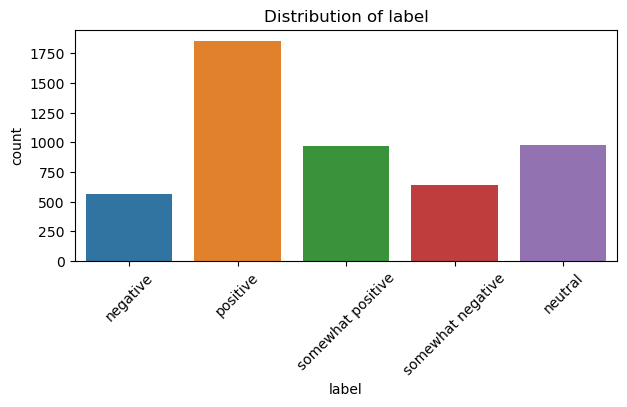

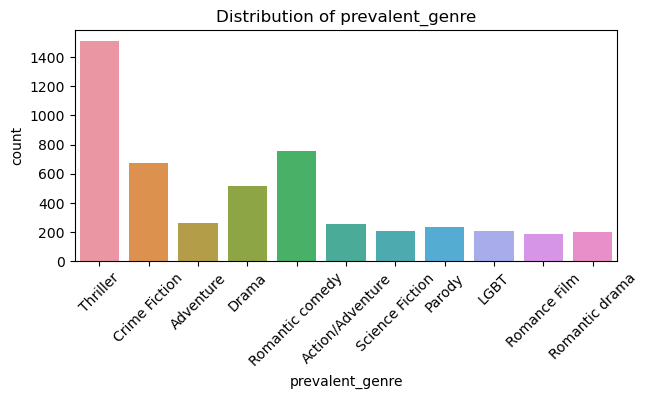

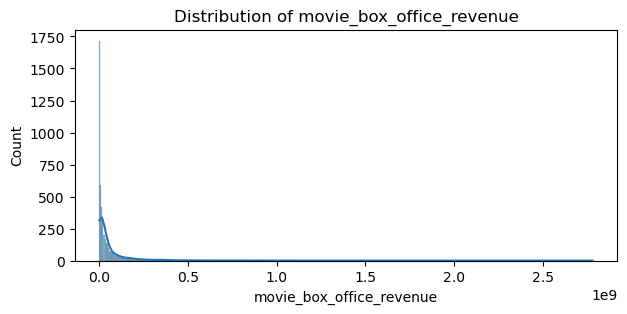

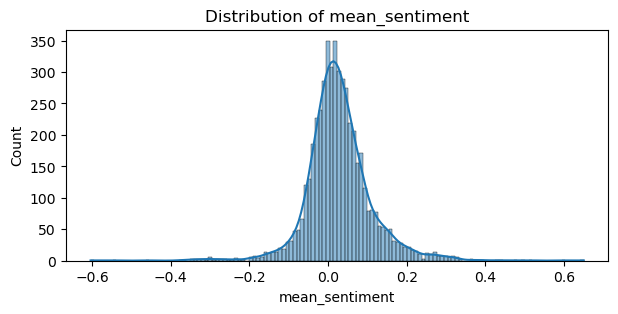

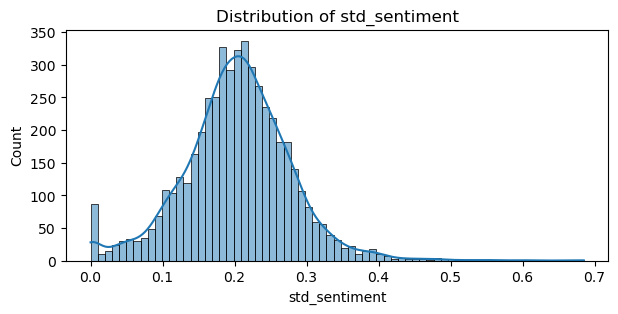

In [33]:
## Distribution of each variable in the dataframe
categorical_columns = ['label', 'prevalent_genre']  # Example categorical columns
numerical_columns = ['movie_box_office_revenue', 'mean_sentiment', 'std_sentiment']  # Example numerical columns

# Plotting distributions for categorical data
for column in categorical_columns:
    plt.figure(figsize=(7, 3))
    sns.countplot(x=column, data=df_ml)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
    plt.show()

# Plotting distributions for numerical data
for column in numerical_columns:
    plt.figure(figsize=(7, 3))
    sns.histplot(df_ml[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()


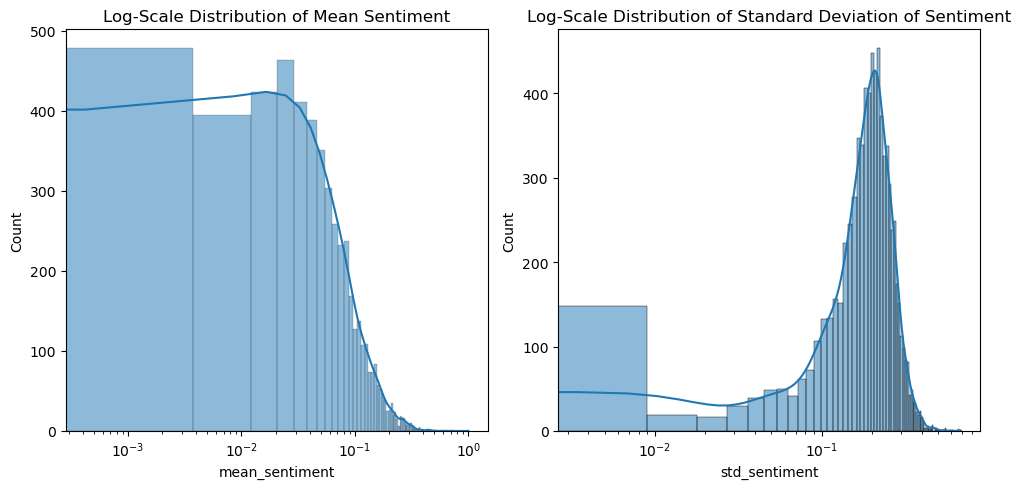

In [34]:
# Plotting the original distributions on a log scale
plt.figure(figsize = (10, 5))

# Plot for mean_sentiment
plt.subplot(1, 2, 1)
sns.histplot(df['mean_sentiment'], kde = True)
plt.xscale('log')
plt.title('Log-Scale Distribution of Mean Sentiment')

# Plot for std_sentiment
plt.subplot(1, 2, 2)
sns.histplot(df['std_sentiment'], kde = True)
plt.xscale('log')
plt.title('Log-Scale Distribution of Standard Deviation of Sentiment')

plt.tight_layout()
plt.show()

### Preparing data for machine learning algorithm

In [35]:
## Encode categorical variables - OPTION 1 : Label Encoding (0,1,...,10,...)
# label_encoders = {}
# for column in df_ml.select_dtypes(include = ['object']).columns:
#     label_encoders[column] = LabelEncoder()
#     df_ml[column] = label_encoders[column].fit_transform(df_ml[column])


# Encode categorical variables - OPTION 2 : One-hot Encoding
categorical_columns = df_ml.select_dtypes(include=['object']).columns
one_hot_encoded_data = pd.get_dummies(df_ml[categorical_columns])

df_ml.drop(columns=categorical_columns, inplace=True)
df_ml = pd.concat([df_ml, one_hot_encoded_data], axis=1)

In [36]:
df_ml.head(2)

,movie_box_office_revenue,wikipedia_movie_id,mean_sentiment,std_sentiment,prevalent_genre_Action/Adventure,prevalent_genre_Adventure,prevalent_genre_Crime Fiction,prevalent_genre_Drama,prevalent_genre_LGBT,prevalent_genre_Parody,prevalent_genre_Romance Film,prevalent_genre_Romantic comedy,prevalent_genre_Romantic drama,prevalent_genre_Science Fiction,prevalent_genre_Thriller,label_negative,label_neutral,label_positive,label_somewhat negative,label_somewhat positive
0,14010832.0,975900,-0.081468,0.282960,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False
3,29381649.0,156558,0.007838,0.151473,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False


In [37]:
## Splitting the data into training and test sets
X = df_ml.drop(columns= ['movie_box_office_revenue', 'wikipedia_movie_id'], axis = 1)  # Features
y = df_ml['movie_box_office_revenue']  # Target variable

## Normalization
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X = pd.DataFrame(X_normalized, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Running the machine learning algorithm

In [38]:
## Building decision tree model
model = DecisionTreeRegressor(random_state = 42)
model.fit(X_train, y_train)

## Predicting and evaluating model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 2.923498388986008e+16


In [39]:
# Building Random Forest model
rf_model = RandomForestRegressor(n_estimators = 50, random_state = 42)
rf_model.fit(X_train, y_train)

# Predicting and evaluating model
rf_y_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_y_pred)
print(f'Random Forest Mean Squared Error: {rf_mse}')


Random Forest Mean Squared Error: 1.264270734467269e+16


Bro I have never seen a mean squared error this big in my whole career as a student lol. Not much difference when using random forest. We will try neural networks, then an algorithm that doesn't need encoding of categorical data.

In [40]:
## Splitting the data into training and test sets
X_nn = df_ml.drop(columns= ['movie_box_office_revenue', 'wikipedia_movie_id'], axis = 1)
y_nn = df_ml['movie_box_office_revenue'].values

# Normalization
scaler = StandardScaler()
X_normalized_nn = scaler.fit_transform(X_nn)
X_nn = pd.DataFrame(X_normalized_nn, columns = X_nn.columns)


X_train, X_test, y_train, y_test = train_test_split(X_nn, y_nn, test_size=0.2, random_state=42)

## Preprocessing
# Define categorical and numerical columns
categorical_cols = X_nn.select_dtypes(include=['object']).columns
numerical_cols = X_nn.select_dtypes(include=['number']).columns

# Create transformers for numerical and categorical data
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_processed.astype(np.float32))
y_train_tensor = torch.tensor(y_train.astype(np.float32))
X_test_tensor = torch.tensor(X_test_processed.astype(np.float32))
y_test_tensor = torch.tensor(y_test.astype(np.float32))

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

## Define simple neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train_processed.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()

# Defining loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [ ]:
# Training 
for epoch in range(10):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

In [ ]:
# Testing 
model.eval()
with torch.no_grad():
    total_loss = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        total_loss += loss.item()
    print(f'Test Loss: {total_loss / len(test_loader)}')